# ResNet34 with CIFAR10

In [108]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.models import resnet34, ResNet34_Weights
import torch
from tqdm.notebook import tqdm
from torch import nn 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [109]:
# Hyperparameters
batch_size = 256
ce_loss = nn.CrossEntropyLoss()
learning_rate = 0.1
weight_decay = 0.001
momentum = 0.1
epoch = 25

## CIFAR-10 Dataset

In [110]:
# Download traning and test data from open datasets --- MNIST
def cifar10():
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = datasets.CIFAR10(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )

    num_classes = 10
    return training_data, test_data, num_classes

In [111]:
#gpu 
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Using {} device \n".format(device))

# Dataloader
training_data, test_data, NUM_CLASSES = cifar10()
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Using cuda device 

Files already downloaded and verified
Files already downloaded and verified


## Model

In [112]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad=False
model.fc = nn.Linear(512, 10)
model = model.to(device)
# preprocess = model.transforms()
# img_transformed = preprocess(img)


In [113]:
# model = ResNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, min_lr=1e-4)

In [114]:
# Accuracy 
def accuracy(y_pred, target):
    train_acc = torch.sum(torch.argmax(y_pred, dim=1) == target)
    final_train_acc = train_acc/target.shape[0]
    return final_train_acc * 100

In [115]:
all_train_losses=[]
all_test_losses=[]
all_train_accuracy=[]
all_test_accuracy=[]

In [116]:
def train():
    cur_step = 0
    for features, label in train_dataloader:
        logits = model(features.to(device))
        label = label.to(device)

        loss = ce_loss(logits, label)
        accuracy_batch = accuracy(logits, label)
        all_train_losses.append(loss.item())
        all_train_accuracy.append(accuracy_batch.item())

        optimizer.zero_grad()
        loss.backward()
        if cur_step % 100 == 0:
           print('\033[32m' + f"Step = {cur_step}, Train Loss = {loss:.3f}, Train Accuracy = {accuracy_batch:.2f}%" + '\033[0m')
        optimizer.step()
        cur_step += 1

In [117]:
def test():
    model.eval()
    total_loss = 0
    total_accuracy = 0
    step = 0
    
    for features, label in test_dataloader:
        with torch.no_grad():
            logits = model(features.to(device))
            label = label.to(device)
            loss = ce_loss(logits, label)
            total_loss += loss.item()
            accuracy_batch = accuracy(logits, label)
            total_accuracy += accuracy_batch.item()
            step += 1
    total_loss = total_loss / step
    total_accuracy = total_accuracy /step

    all_test_losses.append(total_loss)
    all_test_accuracy.append(total_accuracy)
    print('\033[31m' + f"Test Loss = {total_loss:.3f}, Test Accuracy = {total_accuracy:.2f}%" + '\033[0m')
    model.train()
    return total_loss

In [118]:
for i in tqdm(range(epoch)):
    print()
    print('\033[34m' + f"Epoch {i+1}" + '\033[0m')
    train()
    test_loss = test()
    scheduler.step(test_loss)
    print(f"Learning Rate = {optimizer.param_groups[0]['lr']}")

  0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1
Step = 0, Train Loss = 2.527, Train Accuracy = 12.89%
Step = 100, Train Loss = 2.199, Train Accuracy = 38.67%
Test Loss = 2.576, Test Accuracy = 29.98%
Learning Rate = 0.1

Epoch 2
Step = 0, Train Loss = 2.907, Train Accuracy = 24.22%
Step = 100, Train Loss = 1.877, Train Accuracy = 44.92%
Test Loss = 2.309, Test Accuracy = 34.24%
Learning Rate = 0.1

Epoch 3
Step = 0, Train Loss = 2.452, Train Accuracy = 33.98%
Step = 100, Train Loss = 2.265, Train Accuracy = 42.58%
Test Loss = 2.194, Test Accuracy = 36.83%
Learning Rate = 0.1

Epoch 4
Step = 0, Train Loss = 2.215, Train Accuracy = 38.28%
Step = 100, Train Loss = 1.675, Train Accuracy = 48.44%
Test Loss = 2.310, Test Accuracy = 32.01%
Learning Rate = 0.010000000000000002

Epoch 5
Step = 0, Train Loss = 2.393, Train Accuracy = 32.03%
Step = 100, Train Loss = 1.397, Train Accuracy = 55.08%
Test Loss = 1.535, Test Accuracy = 49.39%
Learning Rate = 0.010000000000000002

Epoch 6
Step = 0, Train Loss = 1.518, Train Accuracy = 44.92

In [119]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

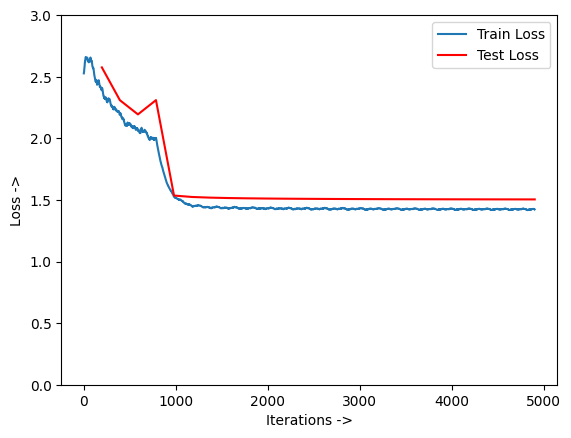

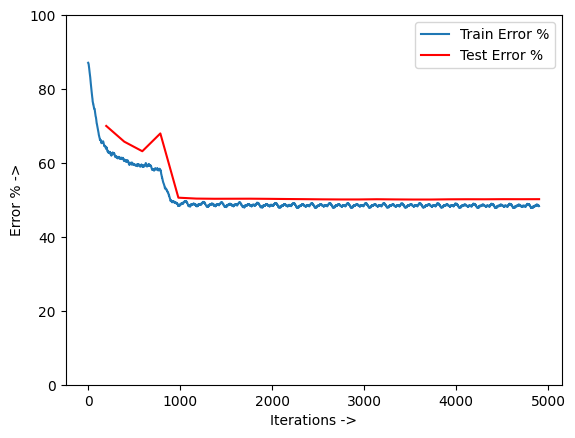

In [120]:
import numpy as np
plt.plot(smooth(all_train_losses, 0.99), label='Train Loss')
steps_per_epoch = len(train_dataloader)
test_iterations = [steps_per_epoch*(i+1) for i in range(epoch)]
plt.plot(test_iterations, all_test_losses, label='Test Loss', color='red')
plt.ylim([0, 3.0])
plt.xlabel('Iterations ->')
plt.ylabel('Loss ->')
plt.legend()
plt.show()

all_train_error = 100 - np.array(all_train_accuracy)
all_test_error = 100 - np.array(all_test_accuracy)
plt.plot(smooth(all_train_error, 0.98), label='Train Error %')
plt.plot(test_iterations, all_test_error, label='Test Error %', color='red')
plt.xlabel('Iterations ->')
plt.ylabel('Error % ->')
plt.ylim([0, 100])
plt.legend()
plt.show()

In [121]:
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 10]                 --
├─Conv2d: 1-1                            [256, 64, 16, 16]         (9,408)
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         (128)
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           (36,864)
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           (128)
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           (36,864)
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           (128)
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]   

: 